*Copyright (C) 2022 Intel Corporation*<br>
*SPDX-License-Identifier: BSD-3-Clause*<br>
*See: https://spdx.org/licenses/*

---

# Excitatory-Inhibitory Neural Network with Lava

**Motivation**: In this tutorial, we will build a Lava Process for a neural networks of excitatory and inhibitory neurons (E/I network). <br>
E/I networks are a fundamental example of neural networks mimicking the structure of the brain and exhibiting rich dynamical behavior. <br>
We will investigate some of their dynamical properties for different instantiations, especially the transition to a critical state which can be harnessed in reservoir computing as well as self-balancing and the role of the recurrently generated activations in this. <br>

#### This tutorial assumes that you:
- have the [Lava framework installed](../in_depth/tutorial01_installing_lava.ipynb "Tutorial on Installing Lava")
- are familiar with the [Process concept in Lava](../in_depth/tutorial02_processes.ipynb "Tutorial on Processes")

#### This tutorial gives a bird's-eye view of
- how with Lava you can implement a simple E/I Network Lava Process
- hot to define and select multiple ProcessModels for the E/I Network, based on Rate and [Leaky Integrate-and-Fire (LIF)](https://github.com/lava-nc/lava/tree/main/src/lava/proc/lif "Lava's LIF neuron") neurons

(Add diagram)

#### E/I Network

From bird's-eye view, an E/I network is a recurrently coupled network of neurons consisting of two populations of neurons. <br>
Since positive couplings (excitatory synapses) alone lead to a positive feedback loop ultimately causing a divergence in the activity of the network, appropriate negative couplings (inhibitory synapses) need to be introduced to counterbalance this effect.<br>
Additionaly, we here require a separation of the neurons into two classes (the populations): Neurons can either be inhibitory or excitatory. <br>
Finally, we introduce a control parameter with which we are able to change the response properties of the network. <br>
In this tutorial, we build a Lava Process for an E/I network. <br>
Our description is agnostic towards the neuron model that governs the dynmical behavior. Considering an E/I network as a Lava Process, instantiations with different neuron models correspond to different ProcessModels.<br>
We here implement different ProcessModels for an E/I network Process using rate and spiking neuron. <br>

#### General imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt

#### E/I Network Lava Process
We define the structure of the E/I Network Lava Process class. <br>

In [2]:
# Import Process level primitives
from lava.magma.core.process.process import AbstractProcess
from lava.magma.core.process.variable import Var
from lava.magma.core.process.ports.ports import InPort, OutPort

In [3]:
class EINetwork(AbstractProcess):
    """Network of recurrently connected neurons
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
        shape_exc = kwargs.pop("shape_exc", (1,))
        bias_exc = kwargs.pop("bias_exc", 1)
        shape_inh = kwargs.pop("shape_inh", (1,))
        bias_inh = kwargs.pop("bias_inh", 1)
        # Factor controlling strength of inhibitory synapses relative to excitatory synapses
        self.g_factor = kwargs.pop("g_factor", 4)
        # Factor controlling response properties of network.
        # Larger q_factor -> longer lasting effect of provided input
        self.q_factor = kwargs.pop("q_factor", 1)
        weights = kwargs.pop("weights", None)
        
        full_shape = shape_exc + shape_inh
        
        self.state = Var(shape=(full_shape,), init=0)
        self.shape_exc = Var(shape=(1,), init=shape_exc)
        self.shape_inh = Var(shape=(1,), init=shape_inh)
        self.bias_exc = Var(shape=(shape_exc,), init=bias_exc)
        self.bias_inh = Var(shape=(shape_inh,), init=bias_inh)

        # Ports for receiving input or sending output
        self.inport = InPort(shape=(full_shape,))
        self.outport = OutPort(shape=(full_shape,))
        
        # If weights are not provided construct balanced network where weights are drawn according to
        # a Gaussian distribution with mean 0 and a std of  q_factor ** 2  * sqrt(full_shape)
        # Clip weights so that neurons are either excitatory or inhibitory
        if not weights:
            # Generate connectivity
            # W[i, j] is connection weight from pre-synaptic neuron j to post-synaptic neuron i
            # Set scaled standard deviation of recurrent weights
            J = self.q_factor**2 / np.sqrt(full_shape)
            weights = np.random.normal(0, J,
                                       (full_shape, full_shape))
            
            # Impose constraint that neurons can **either** be excitatory (positive weight)
            # **or** inhibitory (negative weight)
            exc_conns = np.full(weights.shape, True)
            exc_conns[:, shape_exc:] = False # Set entries for inhibitory neurons to False
            inh_conns = np.invert(exc_conns)
            
            mask_pos_weights = (weights > 0)
            mask_neg_weights = (weights < 0)

            # Set negative weights of exciatory neurons to zero and similarly for inhibitory neurons -> induce sparsity
            weights[mask_neg_weights * exc_conns] = 0
            weights[mask_pos_weights * inh_conns] = 0

            # We finally need to increase the inhibitory weights by a factor to control balance
            weights[inh_conns] *= self.g_factor
            
            self.proc_params.overwrite('weights', weights)
            
        self.weights = Var(shape=(full_shape, full_shape), init=weights)

#### ProcessModels for Python execution

In [4]:
# Import parent classes for ProcessModels for Hierarchical Processes
from lava.magma.core.model.py.model import PyLoihiProcessModel
from lava.magma.core.model.sub.model import AbstractSubProcessModel

# Import execution protocol
from lava.magma.core.sync.protocols.loihi_protocol import LoihiProtocol

# Import decorators
from lava.magma.core.decorator import implements, tag, requires

### Rate neurons
We next turn to the different implementations of the E/I Network.
We start with a rate network obeying the equation
\begin{equation}
    \tau\dot{r} =  -r + W \phi(r) + I_{\mathrm{bias}}.
\end{equation}
The rate or state $r$ is a vector containing the excitatory and inhibitory populations. <br>
The dynamics consists of a dampning part ($-r$), a part modelling the recurrent connecitivty ($ W \phi(r)$)
 and an external bias ($I_{\mathrm{bias}})$. <br>
 We discretize the equation as follows:
 \begin{equation}
    r(i + 1) = (1 - dr) \odot r(i) + W \phi(r(i)) \odot dr + I_{\mathrm{bias}} \odot dr
\end{equation}
Potentially different time scales in the neuron dynamics of excitatory and inhibitory neurons as well as different bias currents for these subpopulations are encoded in the vectors $dr$ and $I_{\mathrm{bias}}$.

In [5]:
from lava.magma.core.model.py.type import LavaPyType
from lava.magma.core.model.py.ports import PyInPort, PyOutPort
from lava.magma.core.resources import CPU
from lava.magma.core.model.model import AbstractProcessModel

@implements(proc=EINetwork, protocol=LoihiProtocol)
@tag('rate_neurons') # tag allows for easy selection of ProcessModel in case multiple are defined
@requires(CPU)
class RateEINetworkModel(PyLoihiProcessModel):

    outport: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, float)
    inport: PyInPort = LavaPyType(PyInPort.VEC_DENSE, float)    
    state : np.ndarray = LavaPyType(np.ndarray, float)
    shape_exc : int = LavaPyType(int, int)
    shape_inh : int = LavaPyType(int, int)
    bias_exc : np.ndarray = LavaPyType(np.ndarray, float)
    bias_inh : np.ndarray = LavaPyType(np.ndarray, float)
    weights : np.ndarray = LavaPyType(np.ndarray, float)

    def __init__(self, proc):
        super().__init__(proc_params=proc)
        
        self.dr_exc = proc.get('dr_exc')
        self.dr_inh = proc.get('dr_inh')
        
        self.proc = proc
        
        self.got_decay = False
        self.got_bias = False
        self.weights_scaled = False
        
    def get_decay(self):
        '''Construct decay factor
        '''
        dr_full = np.array([self.dr_exc] * self.shape_exc + [self.dr_inh] * self.shape_inh)
        self.decay = 1 - dr_full
        
        self.got_decay= True
        
    def get_bias(self):
        '''Construce biases
        '''
        self.bias_full = np.hstack([self.bias_exc, self.bias_inh])
        self.got_bias = False 
        
    def scale_weights(self):
        '''Scale the weights with integration time step
        '''
        exc_conns = np.full(self.weights.shape, True)
        exc_conns[:, self.shape_exc:] = False # Set entries for inhibitory neurons to False
        inh_conns = np.invert(exc_conns)
        
        self.weights[exc_conns] *= self.dr_exc
        self.weights[inh_conns] *= self.dr_inh
        self.proc.overwrite('weights', self.weights)
        
        self.weights_scaled = True
        
    def state_update(self, state):
        """Update network state according to 
            r[i + 1] = (1 - dr)r[i] + Wr[i]*r*dr + bias*dr
        """
        state_new = self.decay * state # decay state
        state_new += self.bias_full # add bias
        state_new += self.weights @ np.tanh(state) # add recurrent input
        return state_new
    
    def run_spk(self):
        """The run function that performs the actual computation during
        execution orchestrated by a PyLoihiProcessModel using the
        LoihiProtocol.
        """
        
        if not self.got_decay:
            self.get_decay()
            
        if not self.got_bias:
            self.get_bias()
            
        if not self.weights_scaled:
            self.scale_weights()
        
        a_in = self.inport.recv()
        self.state = self.state_update(self.state) + a_in
        self.outport.send(self.state)
        

#### Defining the parameters for the network
Next, we need to constrain the network with the needed parameters. <br>
First, we define the dimensionality of the network. Since the neurons in an E/I network tend to low correlations and decouple, we identify the dimensionality with the total number of neurons in the network. <br>
Moreover, we need to set the parameters for the excitatory and inhibitory neurons
For the recurrent connecitivty we employ the generation method defined in the class. <br>
The weights must *balance* the network, i.e. the average recurrent input to a neuron must be less or equal than $0$.  Otherwise, the network activity is caught up in a positive feedback loop and diverges. <br>
We here follow the common choice that the ratio between the number of excitatory and inhibitory neurons equals $4$ and that the connection probability between two arbitrary neurons is identical. <br>
Since the connection probability between two arbitrary neurons is equal, we therefore need to increase the strength of the inhibitory weights, the `g_factor`, to at least $4$. <br>
Finally, we set a parameter that controls the response properties of the network by scaling up the recurrent weights, the `q_factor`.

In [6]:
# Fix randomness
np.random.seed(1234)

# Dimensionality of network
dim = 400
shape = (dim,)

# We represented the dimensionality by 400 neurons. As stated above 80% of the neurons will be excitatory
num_neurons_exc = int(dim * 0.8)
num_neurons_inh = dim - num_neurons_exc

# Single neuron paramters
# Bias_mant is set to make the neuron spike
lif_params_exc = {
    "shape_exc": num_neurons_exc,
    "dr_exc": 0.01,
    "bias_exc": 0.101}

lif_params_inh = {
    "shape_inh": num_neurons_inh,
    "dr_inh": 0.01,
    "bias_inh": 0.101}

# Inhibition-exciation balance for scaling inhibitory weights to maintain balance (4 times as many excitatory neurons)
g_factor = 4

# Factor controlling the
q_factor = 1

# Parameters Paramters for E/I network
network_params_balanced = {}

network_params_balanced.update(lif_params_exc)
network_params_balanced.update(lif_params_inh)
network_params_balanced['g_factor'] = g_factor
network_params_balanced['q_factor'] = q_factor
network_params_balanced['weights'] = None

#### Execution and Results

In [7]:
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi1SimCfg
# Import io processes
from lava.proc.io import sink, source
from lava.proc.monitor.process import Monitor

# Configurations for execution
num_steps = 700
rcfg = Loihi1SimCfg(select_tag='rate_neurons')
run_cond = RunSteps(num_steps=num_steps)

# Instantiating network and IO processes
network_balanced = EINetwork(**network_params_balanced)
state_monitor = Monitor()

state_monitor.probe(target=network_balanced.state,  num_steps=num_steps)

# Run the network
network_balanced.run(run_cfg=rcfg, condition=run_cond)
states_balanced = state_monitor.get_data()[network_balanced.name][network_balanced.state.name]
network_balanced.stop()

#### Visualizing the acitvity
We first have a look at the trajectories of the some neurons in the network

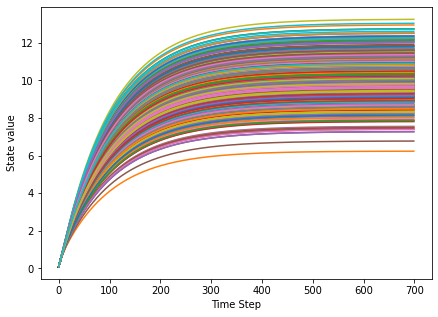

In [8]:
plt.figure(figsize=(7,5))
plt.xlabel('Time Step')
plt.ylabel('State value')
plt.plot(states_balanced)
plt.show()

#### Controlling the network
We see that the states of the neurons quickly converge to a fixed point: the network does not exhibit any non-trivial behavior. <br>
The situation is even worse: One can show that this fixed point is the only fixed point of the system. This means, that after a perturbation of the network, the activity quickly relapses to the stable state. Hence, the network is incapable of performing any meaningful computation. <br>
The reason for this fixed point is, that the dampning part dominates the dynamical behavior - we need to increase the weights! <br>
This we can achive by increasing the `q_factor`.

In [9]:
# Fix randomness
np.random.seed(1234)

# Changing the strenghts of the recurrent connections
network_params_critical = network_params_balanced.copy()
network_params_critical['q_factor'] = 10 * network_params_critical['q_factor']

# Configurations for execution
num_steps = 1000
rcfg = Loihi1SimCfg(select_tag='rate_neurons')
run_cond = RunSteps(num_steps=num_steps)

# Instantiating network and IO processes
network_balanced = EINetwork(**network_params_critical)
state_monitor = Monitor()

state_monitor.probe(target=network_balanced.state,  num_steps=num_steps)

# Run the network
network_balanced.run(run_cfg=rcfg, condition=run_cond)
states_critical = state_monitor.get_data()[network_balanced.name][network_balanced.state.name]
network_balanced.stop()

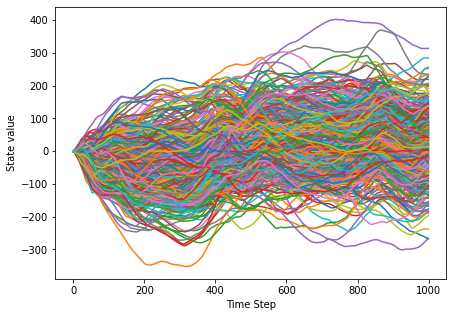

In [10]:
plt.figure(figsize=(7,5))
plt.xlabel('Time Step')
plt.ylabel('State value')
plt.plot(states_critical)
plt.show()

We find that after increasing the `q_factor`, the network shows a very different behavior. The stable fixed point is gone, instead we observe chaotical network dynamics: <br>
The single neuron trajectories behave unpredictably and fluctuate widely, small alterations would lead to completely different states.

#### Further analysis
A characteristic quantity of the network activity is the *auto-correlation function* $c(\tau)$. <br>
With this function, one can assess the *memory* of the network. <br>
Denoting the network activity by $a$, the *auto-correlation function* is the Pearson correlation (here denoted $\mathrm{Corr}(\cdot, \cdot)$) of $a$ with a time shifted version of itself:
\begin{equation}
    c(\tau) = \mathrm{Corr}(a(t), a(t+\tau))
\end{equation}
This means for positive $\tau$ the value of the auto-correlation function gives a measure for the similarity of the network state $a(t)$ and $a(t+\tau)$. <br>
If $c(\tau)$ is significantly greater than zero for large $\tau$, the network has *memory* of its previous states.

In [11]:
from scipy.stats import pearsonr

def auto_corr_fct(acts, max_lag=75):
    """Auto-correlation function of parallel spike trains
    
    Parameters
    ----------
    
    acts : np.ndarray shape (num_neurons, timesteps)
        Activity of neurons, a spike is indicated by a one    
    max_lag : int
        Maximal lag for compuation of auto-correlation function
        
    Returns:
    
    lags : np.ndarray
        lags for auto-correlation function
    auto_corr_fct : np.ndarray
        auto-correlation function
    """
    assert max_lag < acts.shape[1], 'Maximal lag must be smaller then total number of time points'
    auto_corr_fct = np.zeros(2 * max_lag + 1)
    lags = np.linspace(-1 * max_lag, max_lag, 2 * max_lag + 1, dtype=int)
    
    for i, lag in enumerate(lags):
        shifted_acts = np.roll(acts, shift=lag, axis=1)
        auto_corrs = np.zeros(acts.shape[0])
        for j, act in enumerate(acts):
            auto_corrs[j] = pearsonr(act, shifted_acts[j])[0]
        auto_corr_fct[i] = np.mean(auto_corrs)
        
    return lags, auto_corr_fct
    

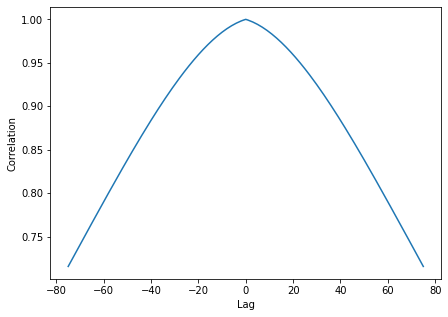

In [12]:
lags, ac_fct = auto_corr_fct(acts=states_critical.T)

# Plotting the auto-correlation function
plt.figure(figsize=(7,5))
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.plot(lags, ac_fct)

As expected, there is perfect correlation at a time lag of $0$. <br>
We moreover see that for positive time lags still is large. <br>
This means that the network has memory of its previous states: The state at a given point in time influences strongly the the subsequent path of the trajectories of the neurons. <br>
Such a network is able to perform meaningful computation.

### LIF Neurons
We now turn to a E/I networks implementing its dynamic behavior with leaky integrate-and-fire neurons. <br>
For this, we harness the concepts of Hierarchical Lava Processes and SubProcessModels. These allow us to avoid implementing everything ourselves, but rather to use already defined Processes and their ProcessModels to build more complicated programs. <br>
We here use the behavior defined for the [LIF](https://github.com/lava-nc/lava/tree/main/src/lava/proc/lif "Lava's LIF neuron") and [Dense](https://github.com/lava-nc/lava/tree/main/src/lava/proc/dense "Lava's Dense Connectivity") Processes, we define the behavior of the E/I Network Process.

In [13]:
from lava.proc.dense.process import Dense
from lava.proc.lif.process import LIF

@implements(proc=EINetwork, protocol=LoihiProtocol)
@tag('lif_neurons')
class SubEINetworkModel(AbstractSubProcessModel):
    def __init__(self, proc):
        # Fetch values for excitatory neurons or set default
        du_exc = proc.proc_params.get('du_exc')
        dv_exc = proc.proc_params.get('dv_exc')
        vth_exc = proc.proc_params.get('vth_exc')
        bias_mant_exc = proc.proc_params.get('bias_exc')
        bias_exp_exc = proc.proc_params.get('bias_exp_exc', 0)
        
        # Fetch values for inhibitory neurons or set default
        du_inh = proc.proc_params.get('du_inh')
        dv_inh = proc.proc_params.get('dv_inh')
        vth_inh = proc.proc_params.get('vth_inh')
        bias_mant_inh = proc.proc_params.get('bias_inh')
        bias_exp_inh = proc.proc_params.get('bias_exp_inh', 0)
        
        # Create parameters for full network
        du_full = np.array([du_exc] * proc.shape_exc.get('value')
                           + [du_inh] * proc.shape_inh.get('value'))
        dv_full = np.array([dv_exc] * proc.shape_exc.get('value')
                           + [dv_inh] * proc.shape_inh.get('value'))
        vth_full = np.array([vth_exc] * proc.shape_exc.get('value') 
                            + [vth_inh] * proc.shape_inh.get('value'))
        bias_mant_full = np.array([bias_mant_exc] * proc.shape_exc.get('value') 
                                  + [bias_mant_inh] * proc.shape_inh.get('value'))
        bias_exp_full = np.array([bias_exp_exc] * proc.shape_exc.get('value') +
                                 [bias_exp_inh] * proc.shape_inh.get('value'))
        weights = proc.weights.get('value')
        
        # Scale the weights with integration time step
        exc_conns = np.full(weights.shape, True)
        exc_conns[:, proc.shape_exc.get('value'):] = False # Set entries for inhibitory neurons to False
        inh_conns = np.invert(exc_conns)
        
        weights[exc_conns] *= du_exc
        weights[inh_conns] *= du_inh
        
        proc.weights = weights
        
        full_shape = proc.shape_exc.get('value') + proc.shape_inh.get('value')

        # Instantiate LIF and Dense Lava Processes
        self.lif = LIF(shape=(full_shape,),
                       du=du_full,
                       dv=dv_full,
                       vth=vth_full,
                       bias_mant=bias_mant_full,
                       bias_exp=bias_exp_full)

            
        self.dense = Dense(weights=weights)
            
            
        # Recurrently connect neurons to E/I Network
        self.lif.s_out.connect(self.dense.s_in)
        self.dense.a_out.connect(self.lif.a_in)

        # Connect incoming activation to neurons and elicited spikes to ouport
        proc.inport.connect(self.lif.a_in)
        self.lif.s_out.connect(proc.outport)

#### Defining the parameters for the network

In [14]:
# Fix randomness
np.random.seed(1234)

# Dimensionality of network
dim = 400
shape = (dim,)

# We represented the dimensionality by 400 neurons. As stated above 80% of the neurons will be excitatory
num_neurons_exc = int(dim * 0.8)
num_neurons_inh = dim - num_neurons_exc

# Single neuron paramters
# Bias_mant is set to make the neuron spike
lif_params_exc = {
    "shape_exc": num_neurons_exc,
    "vth_exc": 1,
    "du_exc": 0.01,
    "dv_exc": 0.1,
    "bias_exc": 0.101}

lif_params_inh = {
    "shape_inh": num_neurons_inh,
    "vth_inh": 1,
    "du_inh": 0.01,
    "dv_inh": 0.1,
    "bias_inh": 0.101}


# Inhibition-exciation balance for scaling inhibitory weights to maintain balance (4 times as many excitatory neurons)
g_factor = 4

# Factor controlling the
q_factor = 1

# Parameters Paramters for E/I network
network_params_balanced = {}

network_params_balanced.update(lif_params_exc)
network_params_balanced.update(lif_params_inh)
network_params_balanced['g_factor'] = g_factor
network_params_balanced['q_factor'] = q_factor
network_params_balanced['weights'] = None

#### Execution and Results

In [15]:
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi1SimCfg
# Import io processes
from lava.proc import io

from lava.proc.dense.models import PyDenseModelFloat
from lava.proc.lif.models import PyLifModelFloat


# Configurations for execution
num_steps = 700
run_cond = RunSteps(num_steps=num_steps)

class CustomRunConfigFloat(Loihi1SimCfg):
    def select(self, proc, proc_models):
        # customize run config to always use float model for io.sink.RingBuffer
        if isinstance(proc, io.sink.RingBuffer):
            return io.sink.PyReceiveModelFloat
        if isinstance(proc, LIF):
            return PyLifModelFloat
        elif isinstance(proc, Dense):
            return PyDenseModelFloat
        else:
            return super().select(proc, proc_models)
        
rcfg = CustomRunConfigFloat(select_tag='lif_neurons', select_sub_proc_model=True)

# Instantiating network and IO processes
network_balanced = EINetwork(**network_params_balanced)
outport_plug = io.sink.RingBuffer(shape=shape, buffer=num_steps)

network_balanced.outport.connect(outport_plug.a_in)

network_balanced.run(condition=run_cond, run_cfg=rcfg)

# Fetching spiking activity
spks_balanced = outport_plug.data.get()

network_balanced.stop()

#### Visualizing the acitvity
First, we visually inspect to spiking activity of the neurons in the network.<br>
To this end, we display neurons on the vertical axis and mark the time step when a neuron spiked.

In [16]:
def raster_plot(spks, stride=6, fig=None, color='b'):
    """Generate raster plot of spiking activity
    
    Parameters
    ----------
    
    spks : np.ndarray shape (num_neurons, timesteps)
        Spiking activity of neurons, a spike is indicated by a one    
    stride : int
        Stride for plotting neurons
    """
    num_time_steps = spks.shape[1]
    assert stride < num_time_steps, "Stride must be smaller than number of time steps"
    
    time_steps = np.arange(0, num_time_steps, 1)
    if fig is None:
        fig = plt.figure(figsize=(10,5))
    timesteps = spks.shape[1]
    
    plt.xlim(-1, num_time_steps)
    plt.yticks([])
    
    plt.xlabel('Time steps')
    plt.ylabel('Neurons')
    
    for i in range(0, dim, stride):
        spike_times = time_steps[spks[i] == 1]
        plt.plot(spike_times,
                 i * np.ones(spike_times.shape),
                 linestyle=' ',
                 marker='o',
                 markersize=1.5,
                 color=color)
        
    return fig       

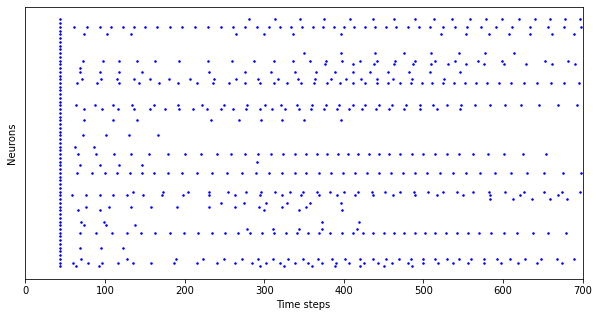

In [17]:
fig = raster_plot(spks=spks_balanced)


After an initial synchronous burst (all neurons are simultaneously driven to the threshold by the external current), we observe an immediate decoupling of the single neuron activities due to the recurrent connectivity.<br>
Overall, we see a heterogeneous network state with asynchronous spiking across neurons.

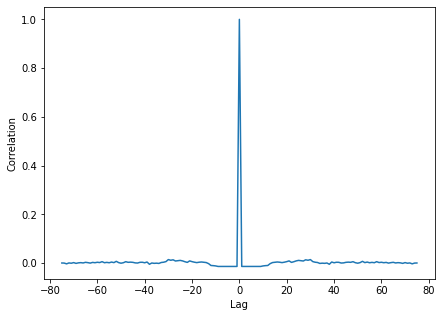

In [18]:
lags, ac_fct = auto_corr_fct(acts=spks_balanced)

# Plotting the auto-correlation function
plt.figure(figsize=(7,5))
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.plot(lags, ac_fct)

Examining the auto-correlation function, we see that for non-vanishing time lags the correlation is close to zero. <br>
This means that the network has no memory of its previous states: Already after one time step we lost almost all information of the previous network state. <br>
Such a network is unfit to perform meaningful computation.

#### Controlling the network
Again, the main control parameters we can tune for the above network is the `q_factor`. <br>
Increasing this factors alters the recurrent weights and thereby the strength of the recurrent connectivity. Dynamically, this increase again results in a fundamentally different network state.

In [19]:
# Fix randomness
np.random.seed(1234)

# Changing the strenghts of the recurrent connections
network_params_critical = network_params_balanced.copy()
network_params_critical['q_factor'] = 10 * network_params_critical['q_factor']

rcfg = CustomRunConfigFloat(select_tag='lif_neurons', select_sub_proc_model=True)
run_cond = RunSteps(num_steps=num_steps)

# Creating new new network with changed weights
network_critical = EINetwork(**network_params_critical)
outport_plug = io.sink.RingBuffer(shape=shape, buffer=num_steps)

network_critical.outport.connect(outport_plug.a_in)

network_critical.run(condition=run_cond, run_cfg=rcfg)

# Fetching spiking activity
spks_critical = outport_plug.data.get()

network_balanced.stop()


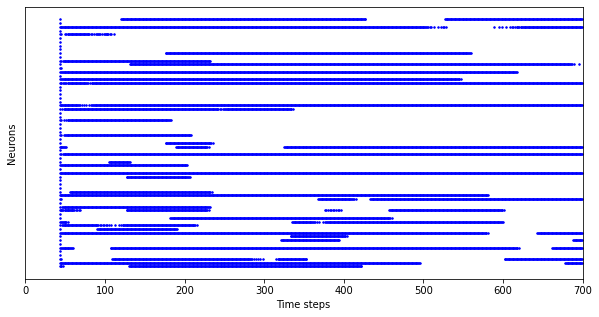

In [20]:
fig = raster_plot(spks=spks_critical)

Here we see a qualitatively different network activity where the recurrent connections play a more dominant role: <br>
At seemingly random times, single neurons enter into active states of variable length. <br>
Next, we have a look at the auto-correlation function of the network.

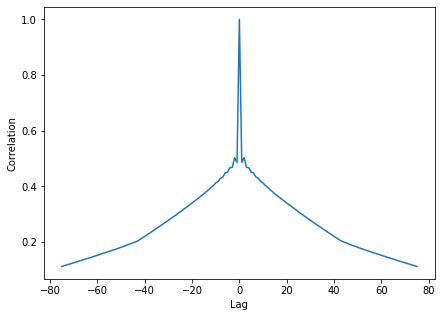

In [21]:
lags, ac_fct_strong_weights = auto_corr_fct(acts=spks_critical)

# Plotting the auto-correlation function
plt.figure(figsize=(7,5))
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.plot(lags, ac_fct_strong_weights)

We observe a slowly decaying auto-correlation function. <br>
These long-lasting temporal correlations are related to a critical network state and the edge of chaos: different inital conditions have a long-lasting effect on the network activity. <br>
This implies the network is in a suitable regime for computation, e.g. in the context of reservoir computing.

#### Self balancing of the network
After having observed these two different dynamical states, we next turn to the question how they come about in the LIF E/I network. <br>
Besides the external currents driving the neurons above threshold and causing the neurons to spike, the recurrently provided activations to the neuron determine the dynamics. <br>
We now examine these activations. Since we know the spike times of the individual neurons as well as the recurrent weights, we may calculate the excitatory, inhibitory as well as total activiation provided to each neuron in both networks.

In [22]:
def calculate_activation(weights, spks, num_exc_neurons):
    """Calculate excitatory, inhibitory and total activation to neurons
    
    Parameters
    ----------
    
    weights : np.ndarray (num_neurons, num_neurons)
        Weights of recurrent connections
    spks : np.ndarray (num_neurons, num_time_steps)
        Spike times of neurons, 0 if neuron did not spike, 1 otherwise
    num_exc_neurons : int
        Number of excitatory neurons
        
    Returns
    -------
    
    activation_exc : np.ndarray (num_neurons, num_time_steps)
        Excitatory activation provided to neurons
    activation_inh : np.ndarray (num_neurons, num_time_steps)
        Inhibitory activation provided to neurons
    activations_total : np.ndarray (num_neurons, num_time_steps)
        Total activation provided to neurons
    """
    
    weights_exc = weights[:, :num_exc_neurons]
    weights_inh = weights[:, num_exc_neurons:]
    
    spks_exc = spks[:num_exc_neurons]
    spks_inh = spks[num_exc_neurons:]
    
    activation_exc = np.matmul(weights_exc, spks_exc)
    activation_inh = np.matmul(weights_inh, spks_inh)
    
    activation_total = activation_exc + activation_inh
    
    return activation_exc, activation_inh, activation_total

Since the network needs some time to settle in it's dynamical state, we discard the first $200$ time steps.

In [23]:
offset = 200

act_exc_balanced, act_inh_balanced, act_tot_balanced \
    = calculate_activation(network_balanced.proc_params.get('weights'),
                          spks_balanced[:,offset:],
                          lif_params_exc['shape_exc'])

act_exc_critical, act_inh_critical, act_tot_critical \
    = calculate_activation(network_critical.proc_params.get('weights'),
                          spks_critical[:,offset:],
                          lif_params_exc['shape_exc'])

First, we look at the distribution of activation of a random neuron in both network states.

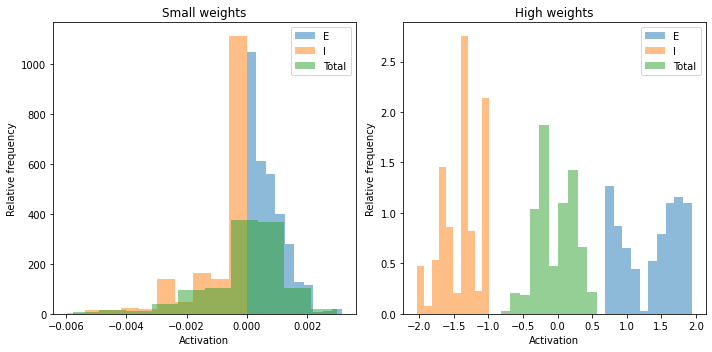

In [24]:
rnd_neuron = 4

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.set_title('Small weights')
ax1.set_xlabel('Activation')
ax1.set_ylabel('Relative frequency')
ax1.hist(act_exc_balanced[rnd_neuron], bins=10, alpha=0.5, density=True, label='E')
ax1.hist(act_inh_balanced[rnd_neuron], bins=10, alpha=0.5, density=True, label='I'),
ax1.hist(act_tot_balanced[rnd_neuron], bins=10, alpha=0.5, density=True, label='Total')
ax1.legend()

ax2.set_title('High weights')
ax2.set_xlabel('Activation')
ax2.set_ylabel('Relative frequency')
ax2.hist(act_exc_critical[rnd_neuron], bins=10, alpha=0.5, density=True, label='E')
ax2.hist(act_inh_critical[rnd_neuron], bins=10, alpha=0.5, density=True, label='I')
ax2.hist(act_tot_critical[rnd_neuron], bins=10, alpha=0.5, density=True, label='Total')
ax2.legend()

plt.tight_layout()
plt.show()

Next, we plot the distribution of the temporal average:

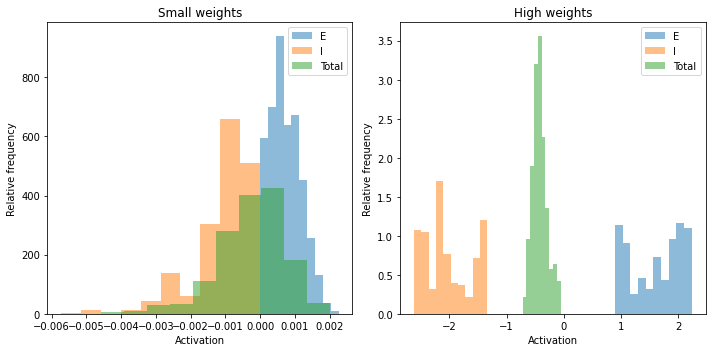

In [25]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.set_title('Small weights')
ax1.set_xlabel('Activation')
ax1.set_ylabel('Relative frequency')
ax1.hist(act_exc_balanced.mean(axis=0), bins=10, alpha=0.5, density=True, label='E')
ax1.hist(act_inh_balanced.mean(axis=0), bins=10, alpha=0.5, density=True, label='I'),
ax1.hist(act_tot_balanced.mean(axis=0), bins=10, alpha=0.5, density=True, label='Total')
ax1.legend()

ax2.set_title('High weights')
ax2.set_xlabel('Activation')
ax2.set_ylabel('Relative frequency')
ax2.hist(act_exc_critical.mean(axis=0), bins=10, alpha=0.5, density=True, label='E')
ax2.hist(act_inh_critical.mean(axis=0), bins=10, alpha=0.5, density=True, label='I')
ax2.hist(act_tot_critical.mean(axis=0), bins=10, alpha=0.5, density=True, label='Total')
ax2.legend()

plt.tight_layout()
plt.show()

We first note that the the total activation is close to zero with a slight shift to negative values.
This self balancing gives the networks stability and prevents the divergence of the activity. <br>
Secondly, we observe that the width of the distributions is orders of magnitude larger in the high weight case as compared to the low weight network. <br>
Finally, we look at the evolution of the mean activation over time. To this end we plot three random sample:

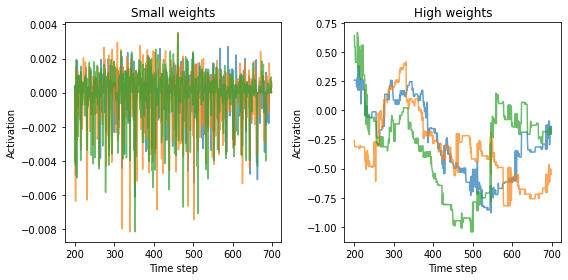

In [26]:
time_steps = np.arange(offset, num_steps, 1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
ax1.set_title('Small weights')
ax1.set_xlabel('Time step')
ax1.set_ylabel('Activation')
for i in range(3):
    ax1.plot(time_steps, act_tot_balanced[i], alpha=0.7)


ax2.set_title('High weights')
ax2.set_xlabel('Time step')
ax2.set_ylabel('Activation')
for i in range(3):
    ax2.plot(time_steps, act_tot_critical[i], alpha=0.7)

plt.tight_layout()
plt.show()

We observe, in accordance with the above histograms, that the distribution of the total activation in  the small weights case is much narrower than in the high weights network. <br>
Moreover, we see that the intrinsic time scale of the fluctuation of the total activation is very different in both networks:
In the high weights network, the fluctuation evolves on a very long time scale as compared to the other network. <br>
This implies that a neuron can sustain it's active, bursting state over longer periods of time leading to memory in the network as well as activity at the edge of chaos: the different states are caused by the *vastly different activation regimes* induced by the recurrent activity. <br>
Finally, note that this property is also seen on the population level.

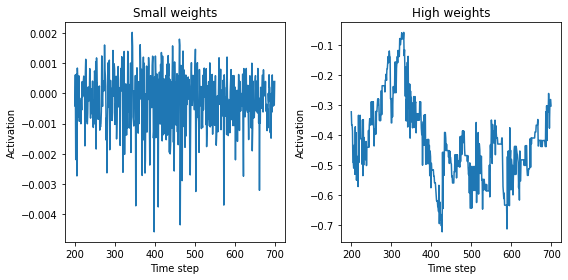

In [27]:
time_steps = np.arange(offset, num_steps, 1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
ax1.set_title('Small weights')
ax1.set_xlabel('Time step')
ax1.set_ylabel('Activation')
ax1.plot(time_steps, act_tot_balanced.mean(axis=0))


ax2.set_title('High weights')
ax2.set_xlabel('Time step')
ax2.set_ylabel('Activation')
ax2.plot(time_steps, act_tot_critical.mean(axis=0))

plt.tight_layout()
plt.show()